In [10]:
import pandas as pd
import numpy as np
import os, json
import pandas as pd
import numpy as np
from datetime import datetime
import h5py
%load_ext autotime
%timeit

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer as knn_impute
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.decomposition import PCA as PCA
from sklearn.cluster import KMeans,MiniBatchKMeans
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from correlation_matrix1 import *

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.97 ms


## Get the latest updated P900 Team level data for 20/21 ##

In [3]:
## Declare P900 Data File Location ##
P900_file = os.path.join(r'C:\Users\Home\Anaconda3\envs\venv\Lib\site-packages\Physical_Visualization','Files','P900_data.xlsx')

def get_last_updated_P900():
    
    P900 = pd.ExcelFile(P900_file)
    df = pd.read_excel(P900, 'Team_Average', usecols=lambda x: 'Unnamed: 0' not in x)

    return df

P900_Team_Data=get_last_updated_P900()

league_list=['GER Bundesliga','ENG Premier League', 'ESP La Liga','ITA Serie A','FRA Ligue 1']

P900_Team_Data1=P900_Team_Data[P900_Team_Data['League'].isin(league_list)].reset_index(drop=True)

del P900_Team_Data1['Season']
del P900_Team_Data1['League']

##Sort out Nulls first with 0 (Check with Mean/Median/Mode)
P900_Team_Data1 = P900_Team_Data1.replace('NULL', 0, regex=True)
P900_Team_Data1 = P900_Team_Data1.replace(np.nan, 0, regex=True)
P900_Team_Data1 = P900_Team_Data1.replace('', 0, regex=True)

time: 8.55 s


In [4]:
import glob
import pandas as pd
import os
os.chdir(r'C:\Users\Home\Documents\Skill Corner Physical Data Correlations\Combined Stats')

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv1 = pd.concat([pd.read_csv(f, sep = ",", encoding= 'unicode_escape' ) for f in all_filenames])

cols=pd.read_csv(r'C:\Users\Home\Documents\Skill Corner Physical Data Correlations\cols.csv', nrows=0)
cols_list=cols.columns

combined_csv1.columns=cols_list

time: 152 ms


## Splitting the P900 data and clustering them based on In-Possession & Out-of Possession ##


## In-Possession ##

No handles with labels found to put in legend.


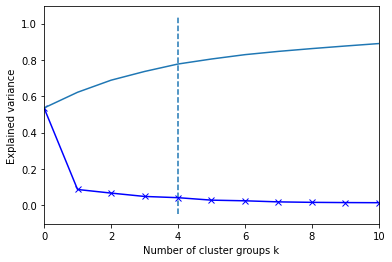

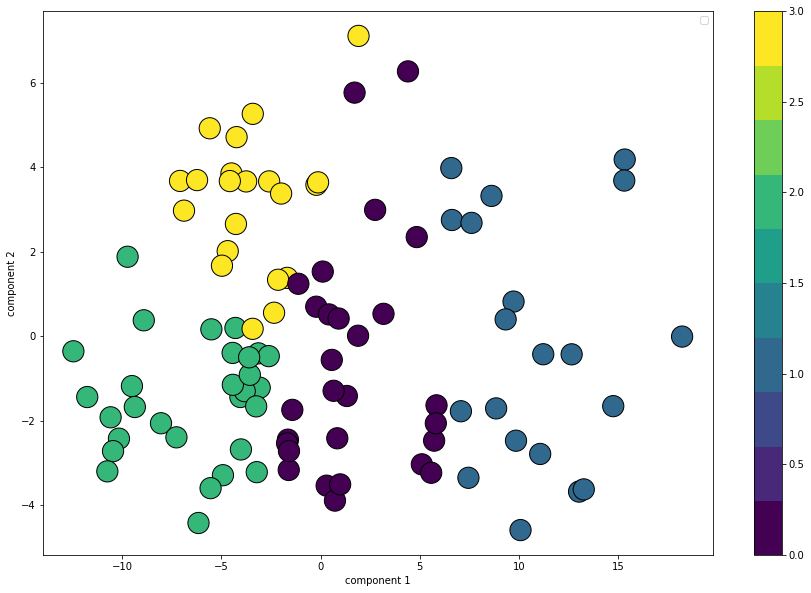

time: 1.59 s


In [42]:
Team_Info=P900_Team_Data1[['Team']]

TIP_Data= P900_Team_Data1.filter(regex=' TIP_|Team')

TIP_Data=pd.merge(TIP_Data,combined_csv1,left_on='Team',right_on='Squad',how='left')

TIP_Data1=TIP_Data[['Squad','League','Team']]

del TIP_Data['Squad']
del TIP_Data['League']
del TIP_Data['Team']
corr_matrix_TIP = TIP_Data.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix_TIP.where(np.triu(np.ones(corr_matrix_TIP.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
TIP_Data2=TIP_Data[to_drop]
corr_matrix_TIP = TIP_Data2.corr().abs()

import scipy.cluster.hierarchy as sch
scaler = StandardScaler()

X = scaler.fit_transform(TIP_Data2)

pca = PCA(n_components = 0.99).fit(X)
x=6
plt.xlabel('Number of cluster groups k')
plt.ylabel('Explained variance')
plt.plot(pca.explained_variance_ratio_, 'bx-')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
from kneed import KneeLocator
pcadf=pd.DataFrame(pca.explained_variance_ratio_)
pcadf['x']=pcadf.index+1
pcadf=pcadf.set_axis(['y', 'x'], axis=1, inplace=False)
kn = KneeLocator(pcadf['x'],pcadf['y'], curve='convex', direction='decreasing')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.xlim(0, 10)


## Implementing the K-means algorithm ##

# fit the model
pca = PCA(n_components=2).fit_transform(X)

# Number of clusters
kmeans = MiniBatchKMeans(n_clusters=4, max_iter=100, n_init=1)
# Fitting the input data
kmeans = kmeans.fit(pca)
# Getting the cluster labels
labels = kmeans.predict(pca)
# Centroid values
C = kmeans.cluster_centers_
clusters = kmeans.labels_.tolist()

array1=pca[:, 0]
array2=pca[:, 1]


fig=plt.figure()
fig.set_size_inches(15, 10)
plt.scatter(pca[:, 0], pca[:, 1],c=clusters,edgecolor='black', alpha=1,
            cmap=plt.cm.get_cmap('viridis', 10),s=450)

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()
plt.colorbar();

plt.grid(False)

TIP_Data['Clusters']=labels

TIP_Data=TIP_Data.reset_index(drop=True)

TIP_Data=pd.merge(TIP_Data,Team_Info, left_index=True, right_index=True)
TIP_Data.to_csv(r'C:\Users\Home\Documents\TIP_Data.csv')
#plt.title('Correlation Matrix - TIP',fontsize=20)
#sns.heatmap(corr_matrix_TIP, annot=True)
#plt.show()

corr_matrix_TIP.to_csv(r'C:\Users\Home\Documents\corr_TIP_Data.csv')

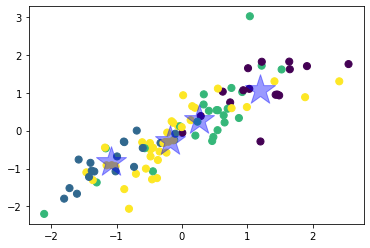

time: 468 ms


In [57]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='blue', s=1000, alpha=0.4,marker="*");

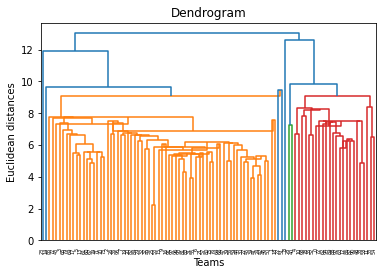

time: 1.93 s


In [17]:
scaler = StandardScaler()

X = scaler.fit_transform(TIP_Data2)

dendrogram = sch.dendrogram(sch.linkage(X, method  = "centroid"))
plt.title('Dendrogram')
plt.xlabel('Teams')
plt.ylabel('Euclidean distances')
plt.show()

In [20]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage ='ward')
# Lets try to fit the hierarchical clustering algorithm  to dataset #X while creating the clusters vector that tells for each customer #which cluster the customer belongs to.
y_hc=hc.fit_predict(X)

time: 2 ms


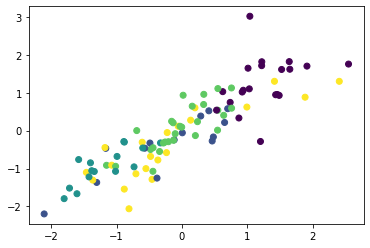

time: 153 ms


In [30]:
labels = hc.labels_

plt.scatter(X[:,0], X[:,1], c=labels)
plt.show()

C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


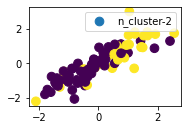

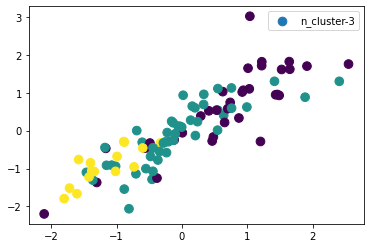

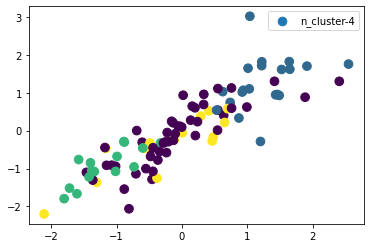

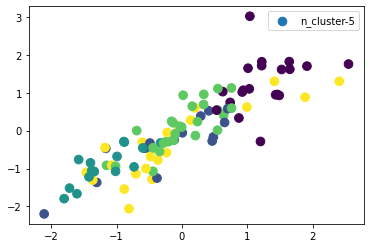

time: 485 ms


In [38]:
f = plt.figure()
f.add_subplot(2, 2, 1)
for i in range(2, 6):
    
    aggloclust=AgglomerativeClustering(n_clusters=i).fit(X)
    f.add_subplot(2, 2, i-1)
    plt.scatter(X[:,0], X[:,1], s=75,c=aggloclust.labels_, label="n_cluster-"+str(i))
    plt.legend()
    plt.show()

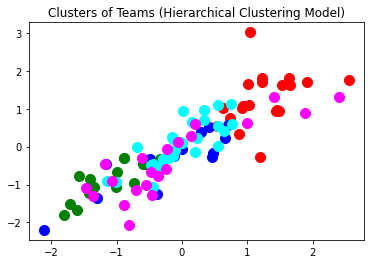

time: 178 ms


In [27]:
#5 Visualizing the clusters. This code is similar to k-means #visualization code. We only replace the y_kmeans vector name to #y_hc for the hierarchical clustering
plt.scatter(X[y_hc==0, 0], X[y_hc==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_hc==1, 0], X[y_hc==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y_hc==2, 0], X[y_hc==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y_hc==3, 0], X[y_hc==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y_hc==4, 0], X[y_hc==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.title('Clusters of Teams (Hierarchical Clustering Model)')
plt.show()

## Out of-Possession ##

No handles with labels found to put in legend.


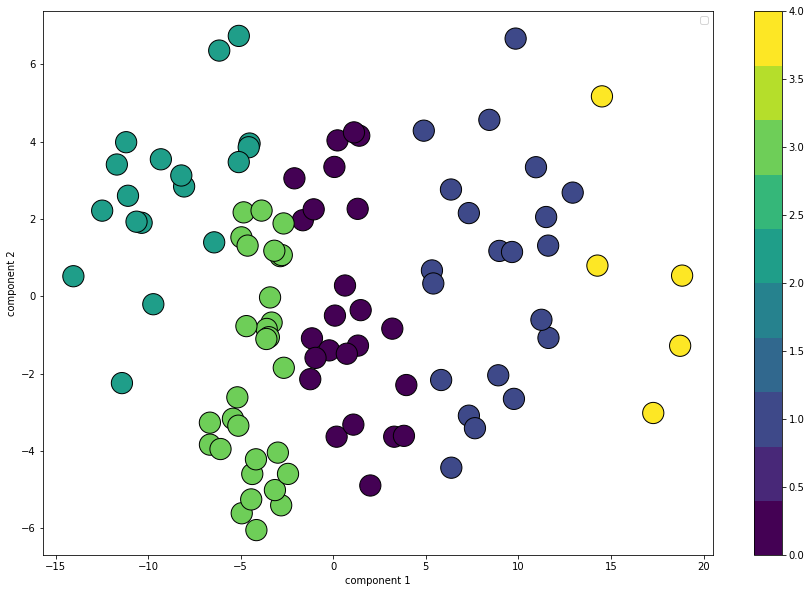

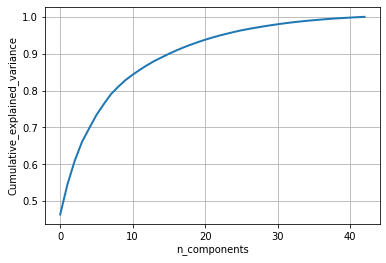

time: 563 ms


In [257]:
## Getting all the columns of when Team is in Possession and Team Out of Possession
Team_Info=P900_Team_Data1[['Team']]
OTIP_Data= P900_Team_Data1.filter(regex='OTIP_|Team')

OTIP_Data=pd.merge(OTIP_Data,combined_csv1,left_on='Team',right_on='Squad',how='left')

OTIP_Data1=OTIP_Data[['Squad','League','Team']]

del OTIP_Data['Squad']
del OTIP_Data['League']
del OTIP_Data['Team']

corr_matrix_OTIP = OTIP_Data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix_OTIP.where(np.triu(np.ones(corr_matrix_OTIP.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]
OTIP_Data2=OTIP_Data[to_drop]

scaler = StandardScaler()

X = scaler.fit_transform(OTIP_Data2)

pca1 = PCA(n_components = 0.99).fit(X)
plt.xlabel('Number of cluster groups k')
plt.ylabel('Explained variance')
plt.plot(pca1.explained_variance_ratio_, 'bx-')
plt.plot(np.cumsum(pca1.explained_variance_ratio_))

from kneed import KneeLocator
pcadf=pd.DataFrame(pca1.explained_variance_ratio_)
pcadf['x']=pcadf.index+1
pcadf=pcadf.set_axis(['y', 'x'], axis=1, inplace=False)
kn = KneeLocator(pcadf['x'],pcadf['y'], curve='convex', direction='decreasing')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.xlim(0, 10)


## Implementing the K-means algorithm ##

# fit the model
pca = PCA(n_components=2).fit_transform(X)

# Number of clusters
kmeans = MiniBatchKMeans(n_clusters=5, max_iter=100, n_init=1)
# Fitting the input data
kmeans = kmeans.fit(pca)
# Getting the cluster labels
labels = kmeans.predict(pca)
# Centroid values
C = kmeans.cluster_centers_
clusters = kmeans.labels_.tolist()

array1=pca[:, 0]
array2=pca[:, 1]


fig=plt.figure()
fig.set_size_inches(15, 10)
plt.scatter(pca[:, 0], pca[:, 1],c=clusters,edgecolor='black', alpha=1,
            cmap=plt.cm.get_cmap('viridis', 10),s=450)

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()
plt.colorbar();

plt.grid(False)

OTIP_Data['Clusters']=labels

OTIP_Data=OTIP_Data.reset_index(drop=True)

OTIP_Data=pd.merge(OTIP_Data,Team_Info, left_index=True, right_index=True)
OTIP_Data.to_csv(r'C:\Users\Home\Documents\OTIP_Data.csv')

percentage_var_explained = pca1.explained_variance_ / np.sum(pca1.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


corr_matrix_OTIP.to_csv(r'C:\Users\Home\Documents\corr_OTIP_Data.csv')

In [146]:
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        #print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))    

    return best_dist

time: 1.99 ms


In [149]:
TIP_Data1=TIP_Data.iloc[:,:-2]
OTIP_Data1=OTIP_Data.iloc[:,:-2]


A=[]
B=[]

cols=TIP_Data1.columns

for i in cols:
    Distributions=get_best_distribution(TIP_Data1[i])
    A.append(Distributions)
    B.append(i)
    
Distributions=pd.DataFrame({'Column Name':B,'Distribution':A})
    

Best fitting distribution: norm
Best fitting distribution: norm
Best fitting distribution: norm
Best fitting distribution: norm
Best fitting distribution: genextreme
Best fitting distribution: genextreme
Best fitting distribution: genextreme
Best fitting distribution: norm
Best fitting distribution: genextreme
Best fitting distribution: norm
Best fitting distribution: genextreme
Best fitting distribution: genextreme
Best fitting distribution: genextreme
time: 5.86 s


In [110]:
import glob
import pandas as pd
import os
os.chdir(r'C:\Users\Home\Documents\Skill Corner Physical Data Correlations\Combined Stats')

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv1 = pd.concat([pd.read_csv(f, sep = ",", encoding= 'unicode_escape' ) for f in all_filenames])

cols=pd.read_csv(r'C:\Users\Home\Documents\Skill Corner Physical Data Correlations\cols.csv', nrows=0)
cols_list=cols.columns

combined_csv1.columns=cols_list

time: 152 ms


In [164]:
df=P900_Team_Data1.copy()

df1=pd.merge(df,combined_csv1,left_on='Team',right_on='Squad',how='left')

df2=df1[['Squad','League','Team']]

del df1['Squad']
del df1['League']
del df1['Team']

time: 22.6 ms


In [167]:
df=P900_Team_Data1.copy()

df1=pd.merge(df,combined_csv1[['Squad','Expected Shooting_npxG']],left_on='Team',right_on='Squad',how='left')
df2=df1[['Squad','Team']]
del df1['Team']
del df1['Squad']


time: 7.98 ms


In [176]:
corr_matrix = df1.corr().abs()
#sns.heatmap(corr_matrix, annot=True)
#plt.show()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

#### VIF values:
from statsmodels.stats.outliers_influence import variance_inflation_factor
check=df[to_drop]

# Find index of feature columns with correlation greater than 5
to_drop_vif = vif[vif['VIF Factor'] > 10]
to_drop_vif=list(vif.index)

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
vif.index = df1.columns

### Final columns to drop to remove causation and correlation effect 
final_drop = [e for e in to_drop_vif if e in to_drop]

# Drop features 
dfx=df.drop(final_drop, axis=1)

dfx

C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Team  Minutes_mean  Distance_mean  \
0      Arsenal Football Club         900.0  101835.021244   
1                Aston Villa         900.0   97636.590330   
2   Brighton and Hove Albion         900.0  101169.232406   
3                    Burnley         900.0  101224.523247   
4                    Chelsea         900.0  100853.091624   
..                       ...           ...            ...   
93                 Sampdoria         900.0  104668.700612   
94                  Sassuolo         900.0  101538.987906   
95             Spezia Calcio         900.0  101536.616385   
96                    Torino         900.0   98877.569301   
97                   Udinese         900.0  101743.890406   

    Sprinting Distance_mean  Count Acceleration_mean  Minutes TIP_mean  \
0               1603.466111              1173.514073        296.123156   
1               1717.197627              1136.187735        235.487678   
2               1634.937701              1181.791093        290.243486   
3               1477.511404              1229.877941        214.181842   
4               1740.644672              1276.770428        326.765480   
..                      ...                      ...               ...   
93              1575.168369              1212.666151        264.143676   
94              1502.550358              1138.009003        316.365669   
95              1482.326084              1161.923223        298.149137   
96              1417.335021              1133.138467        265.410517   
97              1805.481116              1211.922497        264.943794   

    HI MMin TIP_mean  MMin OTIP_mean  PSV-99_mean  Match Count  
0         110.273010     1501.382561    28.464151           36  
1         131.941130     1474.133539    28.914142           37  
2         118.711395     1509.917238    28.563755           35  
3         133.390715     1453.420105    28.051643           37  
4         112.436117     1519.574740    28.651529           38  
..               ...             ...          ...          ...  
93        121.060698     1436.822493    27.985716           38  
94        100.739369     1475.541952    28.156393           37  
95        101.689018     1483.311183    28.099869           36  
96        102.556866     1449.412548    28.257796           37  
97        131.833845     1451.095564    28.317619           37  

[98 rows x 10 columns]

time: 147 ms


(0.0, 10.0)

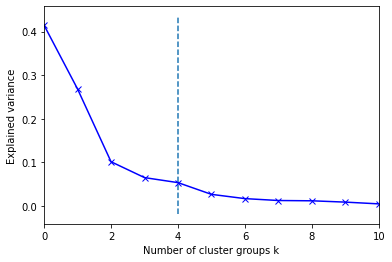

time: 169 ms


In [224]:
import matplotlib.pyplot as plt

scaler = MinMaxScaler()

X = scaler.fit_transform(df1)

pca = PCA(n_components = 0.99).fit(X)
x=15
plt.xlabel('Number of cluster groups k')
plt.ylabel('Explained variance')
plt.plot(pca.explained_variance_ratio_, 'bx-')
from kneed import KneeLocator
pcadf=pd.DataFrame(pca.explained_variance_ratio_)
pcadf['x']=pcadf.index+1
pcadf=pcadf.set_axis(['y', 'x'], axis=1, inplace=False)
kn = KneeLocator(pcadf['x'],pcadf['y'], curve='convex', direction='decreasing')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.xlim(0, 10)

No handles with labels found to put in legend.


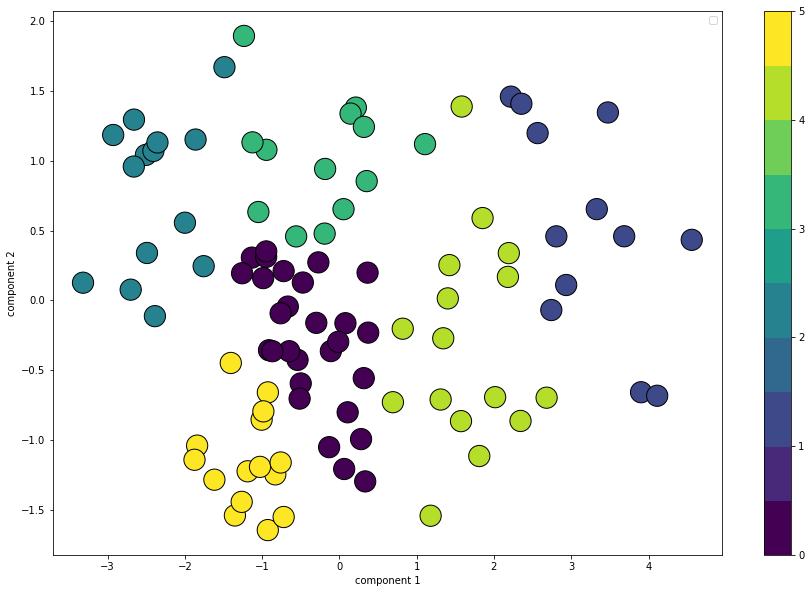

time: 336 ms


In [117]:

### Implementing Minibatch Kmeans ###
from sklearn.cluster import MiniBatchKMeans
from matplotlib import pyplot
from numpy import unique
from numpy import where
from sklearn import preprocessing
from sklearn.decomposition import PCA


scaler = MinMaxScaler()

X = scaler.fit_transform(df1)

# fit the model
pca = PCA(n_components=2).fit_transform(X)

# Number of clusters
kmeans = MiniBatchKMeans(n_clusters=6, max_iter=100, n_init=1)
# Fitting the input data
kmeans = kmeans.fit(pca)
# Getting the cluster labels
labels = kmeans.predict(pca)
# Centroid values
C = kmeans.cluster_centers_
clusters = kmeans.labels_.tolist()

array1=pca[:, 0]
array2=pca[:, 1]


fig=plt.figure()
fig.set_size_inches(15, 10)
plt.scatter(pca[:, 0], pca[:, 1],c=clusters,edgecolor='black', alpha=1,
            cmap=plt.cm.get_cmap('viridis', 10),s=450)

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()
plt.colorbar();

plt.grid(False)

df1['Clusters']=labels
df1['sequence']=df1.index

df1=df1.reset_index(drop=True)

df3=pd.merge(df1,df2, left_index=True, right_index=True)
df3.to_csv(r'C:\Users\Home\Documents\df3.csv')


In [19]:
today= datetime.today().strftime('%Y-%m-%d')
today=pd.to_datetime(today)
df['player_birthdate']=pd.to_datetime(df['player_birthdate'])
df['Age'] = today-df['player_birthdate']
df['Age']=round(df['Age']/np.timedelta64(1,'Y'),2)

df1=df.loc[:,'Count Sprint TIP':'Count Acceleration OTIP']
df

Count Sprint TIP  Count Sprint  Count Deceleration  \
0                    0.0           6.0               117.0   
1                    1.0           1.0                83.0   
2                    5.0          11.0               106.0   
3                    1.0           4.0                53.0   
4                    5.0           9.0               105.0   
...                  ...           ...                 ...   
393710               2.0           3.0                61.0   
393711               1.0           2.0                41.0   
393712               0.0           1.0                21.0   
393713               5.0           6.0               107.0   
393714               4.0           7.0               122.0   

        Count Deceleration TIP  Count Sprint OTIP  Running Distance  \
0                         30.0                5.0            1799.0   
1                         31.0                0.0            1304.0   
2                         52.0                4.0            1499.0   
3                         16.0                2.0             670.0   
4                         16.0                3.0            1518.0   
...                        ...                ...               ...   
393710                    21.0                1.0             788.0   
393711                    11.0                0.0             441.0   
393712                     6.0                1.0             287.0   
393713                    48.0                1.0            1415.0   
393714                    45.0                2.0            1847.0   

        HSR Distance  HSR Distance OTIP  Sprinting Distance TIP  Count HSR  \
0              721.0              492.0                    11.0       60.0   
1              370.0              208.0                    12.0       36.0   
2              673.0              273.0                   105.0       61.0   
3              304.0              212.0                    20.0       26.0   
4              719.0              423.0                    61.0       62.0   
...              ...                ...                     ...        ...   
393710         336.0              119.0                    38.0       30.0   
393711         222.0               88.0                    14.0       20.0   
393712         123.0               65.0                     5.0       10.0   
393713         567.0              231.0                    92.0       47.0   
393714         734.0              260.0                    85.0       61.0   

        ...  HSR Distance TIP  Distance  Count HSR OTIP  Minutes OTIP  \
0       ...             170.0   11128.0            36.0         21.38   
1       ...             162.0    8007.0            18.0         14.88   
2       ...             357.0   10227.0            24.0         21.38   
3       ...              84.0    5091.0            17.0          9.75   
4       ...             265.0   10699.0            35.0         36.90   
...     ...               ...       ...             ...           ...   
393710  ...             182.0    5145.0            12.0         13.77   
393711  ...             109.0    3339.0             7.0         10.00   
393712  ...              50.0    2001.0             4.0          4.08   
393713  ...             284.0    9896.0            16.0         28.37   
393714  ...             406.0   10932.0            22.0         32.24   

        Running Distance OTIP  Minutes TIP  Sprinting Distance  \
0                      1050.0        36.90               147.0   
1                       657.0        25.72                24.0   
2                       607.0        36.90               223.0   
3                       362.0        18.00                77.0   
4                      1041.0        21.38               161.0   
...                       ...          ...                 ...   
393710                  350.0        14.45                80.0   
393711                  174.0         8.60                39.0   
39

time: 143 ms
